In [1]:
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.random_projection import GaussianRandomProjection
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import gc

# 加载数据
with open('train.pkl', 'rb') as f:
    train = pickle.load(f)
with open('df_train.pkl', 'rb') as f:
    df_train = pickle.load(f)

# 删除不需要的列
df_train.drop(['api', 'tid', 'index'], axis=1, inplace=True)

# 按照file_id进行分组，获取API调用序列
def get_apis(df):
    group_fileid = df.groupby('file_id')
    file_api = {}
    for file_id, file_group in group_fileid:
        result = file_group.sort_values(['tid', 'index'], ascending=True)
        api_sequence = ' '.join(result['api'])
        file_api[file_id] = api_sequence
    return file_api

train_apis = get_apis(train)

# 将API调用序列转换为DataFrame并合并
temp = pd.DataFrame.from_dict(train_apis, orient='index', columns=['api'])
temp = temp.reset_index().rename(columns={'index': 'file_id'})
df_train = df_train.merge(temp, on='file_id', how='left')

# 使用TF-IDF进行特征提取并降维
vec = TfidfVectorizer(ngram_range=(1, 4), min_df=0.01, max_df=0.99)
api_features = vec.fit_transform(df_train['api'])

transformer = GaussianRandomProjection(n_components=500)
api_features = transformer.fit_transform(api_features)

df_apis = pd.DataFrame(api_features)

# 合并特征
df_train = df_train.merge(df_apis, left_index=True, right_index=True)
df_train.drop(['api'], axis=1, inplace=True)

# 划分训练集和测试集
train_set, test_set = train_test_split(df_train, test_size=0.2, random_state=2024)



In [2]:
train_set.head(3)

file_id  label  api_count  api_nunique  api_max  api_min    api_std  \
969        970      5       5014           45      281       13  61.476759   
10448    10449      2        536           30      298       25  33.361195   
8807      8808      5        904           44      260        6  45.022417   

         api_mean  api_median  api_ptp  ...       490       491       492  \
969    224.086358       266.0      268  ... -0.029721  0.021516  0.004975   
10448  151.708955       152.0      273  ...  0.059904 -0.047300  0.002108   
8807   188.886062       184.0      254  ... -0.008891  0.055660  0.022642   

            493       494       495       496       497       498       499  
969    0.001574 -0.041580 -0.022911  0.017817  0.024629  0.035650 -0.026723  
10448  0.072316 -0.009885  0.015097  0.038239 -0.036134 -0.052169  0.001229  
8807  -0.014475 -0.010216 -0.040465 -0.024948 -0.080394  0.030864 -0.030401  

[3 rows x 526 columns]

In [3]:
test_set.head(3)

file_id  label  api_count  api_nunique  api_max  api_min    api_std  \
42         43      0         56           18      257       16  64.421260   
682       683      0      14558           91      261        6  51.067117   
7419     7420      0       5001           45      266       18  38.094091   

        api_mean  api_median  api_ptp  ...       490       491       492  \
42    123.714286       134.0      241  ...  0.067486 -0.029423  0.010594   
682   185.000893       187.0      255  ... -0.045312  0.002016  0.063171   
7419  165.667067       151.0      248  ... -0.020149  0.000448 -0.034549   

           493       494       495       496       497       498       499  
42   -0.023737 -0.054137 -0.081132 -0.019686  0.000145 -0.000005  0.017003  
682   0.068724 -0.019055  0.001876 -0.066150  0.037045 -0.013579 -0.018583  
7419 -0.082030 -0.079555 -0.001686  0.111136  0.044189 -0.009287 -0.037557  

[3 rows x 526 columns]

In [4]:
# 训练LightGBM模型
clf = lgb.LGBMClassifier(
    num_leaves=2**5 - 1, reg_alpha=0.25, reg_lambda=0.25, objective='multiclass',
    max_depth=-1, learning_rate=0.005, min_child_samples=3, random_state=2024,
    n_estimators=2000, subsample=1, colsample_bytree=1)

clf.fit(train_set.drop(['file_id', 'label'], axis=1), train_set['label'])
result_lgb = clf.predict_proba(test_set.drop(['file_id', 'label'], axis=1))



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 132563
[LightGBM] [Info] Number of data points in the train set: 11109, number of used features: 523
[LightGBM] [Info] Start training from score -1.025720
[LightGBM] [Info] Start training from score -3.311624
[LightGBM] [Info] Start training from score -2.455896
[LightGBM] [Info] Start training from score -2.817229
[LightGBM] [Info] Start training from score -4.958802
[LightGBM] [Info] Start training from score -1.178700
[LightGBM] [Info] Start training from score -3.258727
[LightGBM] [Info] Start training from score -2.241394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

In [ ]:
# 训练XGBoost模型
model_xgb = xgb.XGBClassifier(
    max_depth=9, learning_rate=0.005, n_estimators=2000,
    objective='multi:softprob', tree_method="hist", subsample=0.8,
    colsample_bytree=0.8, min_child_weight=3, eval_metric='logloss', reg_lambda=0.5)

model_xgb.fit(train_set.drop(['file_id', 'label'], axis=1), train_set['label'])
result_xgb = model_xgb.predict_proba(test_set.drop(['file_id', 'label'], axis=1))

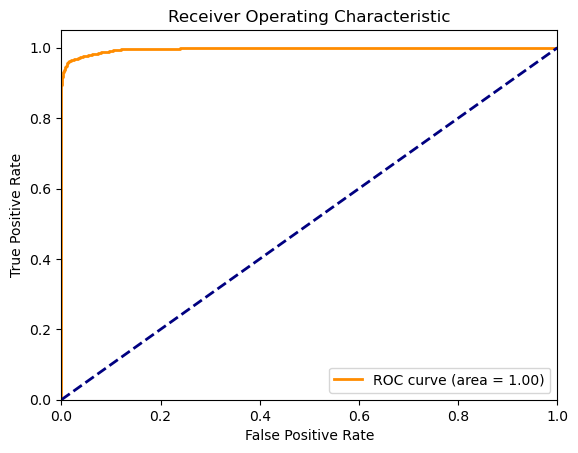

混淆矩阵：
[[ 970   25]
 [  60 1723]]
准确率 (Accuracy): 0.9694024478041756
精确率 (Precision): 0.9856979405034325
召回率 (Recall): 0.9663488502523836
F1分数 (F1 Score): 0.9759274992919853


2924

In [5]:
# 将预测结果合并
result = pd.DataFrame(result_lgb * 0.5 + result_xgb * 0.5, columns=['prob0', 'prob1', 'prob2', 'prob3', 'prob4', 'prob5', 'prob6', 'prob7'])

# 将多分类结果转换为二分类结果
test_set['binary_label'] = (test_set['label'] != 0).astype(int)
binary_preds = result.iloc[:, 1:].sum(axis=1)  # 非0标签的概率和作为恶意软件的概率

# 计算ROC曲线和AUC值
fpr, tpr, thresholds = roc_curve(test_set['binary_label'], binary_preds)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 计算混淆矩阵和性能指标
binary_preds_label = (binary_preds >= 0.5).astype(int)
cm = confusion_matrix(test_set['binary_label'], binary_preds_label)
accuracy = accuracy_score(test_set['binary_label'], binary_preds_label)
precision = precision_score(test_set['binary_label'], binary_preds_label)
recall = recall_score(test_set['binary_label'], binary_preds_label)
f1 = f1_score(test_set['binary_label'], binary_preds_label)

print('混淆矩阵：')
print(cm)
print('准确率 (Accuracy):', accuracy)
print('精确率 (Precision):', precision)
print('召回率 (Recall):', recall)
print('F1分数 (F1 Score):', f1)

# 清理不需要的变量
gc.collect()